In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install gymnasium
!pip install pygame
!pip install wheel setuptools
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379417 sha256=d3926da5e7877f40fab5f25ee77e32e7a04edb8d64bc55f6f1bd9f853efd6e76
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class GaussianActorCriticPPO(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(64, 64)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU()
        )
        self.actor_mean = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], output_dim)
        )
        self.actor_log_std = nn.Parameter(torch.ones(output_dim) * -2)

        self.critic_layer = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], 1)
        )

    def forward(self, x):
        x = self.net(x)
        mean = self.actor_mean(x)
        std = torch.exp(self.actor_log_std)
        value = self.critic_layer(x)
        return mean, std, value


In [3]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import numpy as np
import copy
from datetime import datetime
import gymnasium as gym
import matplotlib.pyplot as plt


# class RolloutBuffer to store variables during training
class RolloutBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.raw_actions = []
        self.rewards = []
        self.next_states = []
        self.logprobs = []
        self.values = []
        self.is_dones = []

    def clear(self):
        self.__init__()


class PPOAgent:
    def __init__(self, env_id, total_timesteps=1e5, max_steps=500, epsilon=float('inf'), gamma=0.99, lambda_GAE=0.95,
                 lr=1e-3, num_steps=0, num_envs=8, num_epochs=4, minibatch_size=4, vectorization_mode="sync", seed=123, is_GAE=False, plot=True, plot_params = [True, False, False, False]):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # using vectorized environments to boost training speed
        if num_envs == 1:
            self.env = gym.make(env_id)
            self.policy_net = GaussianActorCriticPPO(self.env.observation_space.shape[0], self.env.action_space.shape[0]).to(self.device)
        else:
            self.env = gym.make_vec(env_id, num_envs=num_envs, vectorization_mode=vectorization_mode)
            self.policy_net = GaussianActorCriticPPO(self.env.single_observation_space.shape[0], self.env.single_action_space.shape[0]).to(self.device)
        self.num_envs = num_envs
        self.total_timesteps = total_timesteps
        self.num_epochs = num_epochs
        self.max_steps = max_steps
        self.minibatch_size = minibatch_size
        self.epsilon = epsilon
        self.gamma = gamma
        self.lambda_GAE = lambda_GAE
        self.lr = lr
        self.num_steps = num_steps
        self.old_policy_net = copy.deepcopy(self.policy_net)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        # added scheduler after observing divergence after getting close to solving
        self.scheduler = StepLR(self.optimizer, step_size=500 * num_epochs, gamma=0.9)
        self.critic_loss = nn.MSELoss()
        self.seed = seed
        self.buffer = RolloutBuffer()
        self.is_GAE = is_GAE
        self.plot = plot
        self.plot_params = plot_params

    # choosing action from policy's probability distribution
    def choose_action(self, state):
        with torch.no_grad():
            mean, std, value = self.old_policy_net(state)
            action_dist = torch.distributions.Normal(mean, std)
        raw_action = action_dist.rsample()
        action = torch.tanh(raw_action)
        log_prob = action_dist.log_prob(raw_action)
        log_prob -= torch.log(1 - action.pow(2) + 1e-6)
        return action, raw_action, log_prob.sum(-1), value

    # compute the advantages
    def compute_advantages(self, rewards, values, next_value, is_dones):
        if self.num_envs == 1:
            T = rewards.shape[0]
            N = 1
        else:
            T, N = rewards.shape
        returns = torch.zeros_like(rewards)
        R = torch.zeros(N, device=rewards.device)

        for t in reversed(range(T)):
            # forgetting to mask terminal states led R to build up forever.
            R = rewards[t] + self.gamma * R * (1 - is_dones[t])
            returns[t] = R

        # normalize discounted_rewards across all timesteps and environments
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        advantages = returns - values.squeeze()
        return returns, advantages


    # compute the GAE
    def compute_GAE(self, rewards, values, next_value, is_dones):
        if self.num_envs == 1:
            T = rewards.shape[0]
            N = 1
        else:
            T, N = rewards.shape
        advantages = torch.zeros_like(rewards)
        td = torch.zeros(N, device=rewards.device)
        gae = torch.zeros(N, device=rewards.device)
        values = torch.cat([values, next_value.unsqueeze(0)], dim=0)

        for t in reversed(range(T)):
            # temporal difference error
            td = rewards[t] + self.gamma * values[t + 1] * (1 - is_dones[t]) - values[t]
            # higher labmda -> more sampling, lower lambda -> more bootstrapping
            gae = td + self.gamma * self.lambda_GAE * (1 - is_dones[t]) * gae
            advantages[t] = gae

        # compute returns by adding value to advantage
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        returns = advantages + values[:-1]

        return returns, advantages


    def update(self):
        # retrieve info from buffer
        old_states      = torch.stack(self.buffer.states)
        old_actions     = torch.stack(self.buffer.actions)
        old_raw_actions = torch.stack(self.buffer.raw_actions)
        old_rewards     = torch.stack(self.buffer.rewards)
        old_next_states = torch.stack(self.buffer.next_states)
        old_log_probs   = torch.stack(self.buffer.logprobs)
        old_values      = torch.stack(self.buffer.values)
        is_dones        = torch.stack(self.buffer.is_dones)
        _, _, next_value = self.old_policy_net(old_next_states[-1])
        next_value = next_value.squeeze(-1)

        if self.is_GAE:
            with torch.no_grad():
                old_returns, old_advantages = self.compute_GAE(old_rewards, old_values, next_value, is_dones)
                old_returns = old_returns.detach()
                old_advantages = old_advantages.detach()
        else:
            old_returns, old_advantages = self.compute_advantages(old_rewards, old_values, next_value, is_dones)

        batch_size = old_states.shape[0]
        minibatch_size = self.minibatch_size

        for _ in range(self.num_epochs):
            mean, std, values = self.policy_net(old_states)
            action_dist = torch.distributions.Normal(mean, std)
            log_probs = action_dist.log_prob(old_raw_actions)
            log_probs -= torch.log(1 - old_actions.pow(2) + 1e-6)
            log_probs = log_probs.sum(-1)
            prob_ratios = torch.exp(log_probs - old_log_probs.detach())
            values = values.squeeze(-1)

            surrogate = torch.min(
                prob_ratios * old_advantages,
                prob_ratios.clamp(1 - self.epsilon, 1 + self.epsilon) * old_advantages
            )

            actor_loss = -surrogate.mean()
            critic_loss = self.critic_loss(old_returns, values)
            entropy = action_dist.entropy().mean()
            loss = actor_loss + 0.5 * critic_loss - 0.05 * entropy

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        # self.scheduler.step()

        return actor_loss, critic_loss, entropy


    def train(self):
        episode_rewards = [[] for _ in range(self.num_envs)]
        episode_nums = [0] * self.num_envs
        steps = 0
        start_time = datetime.now().replace(microsecond=0)
        actor_losses = []
        critic_losses = []
        entropies = []
        mean_rewards = []

        state, _ = self.env.reset()
        episode_reward = np.zeros(self.num_envs)

        while steps < self.total_timesteps:
            steps += 1
            state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)

            action, raw_action, log_prob, value = self.choose_action(state_tensor)
            value = value.squeeze(-1)
            next_state, reward, terminated, truncated, _ = self.env.step(action.cpu().numpy())
            episode_reward += reward
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(self.device)
            done = np.logical_or(terminated, truncated)

            self.buffer.states.append(state_tensor)
            self.buffer.actions.append(action.clone().detach())
            self.buffer.raw_actions.append(raw_action.clone().detach())
            self.buffer.logprobs.append(log_prob.clone().detach())
            self.buffer.next_states.append(next_state_tensor)
            self.buffer.rewards.append(torch.tensor(reward, dtype=torch.float32).to(self.device))
            self.buffer.is_dones.append(torch.tensor(done, dtype=torch.float32).to(self.device))
            self.buffer.values.append(value.clone().detach())


            for i in np.where(done)[0]:
                episode_rewards[i].append(episode_reward[i])
                episode_nums[i] += 1
                episode_reward[i] = 0

            state = next_state

            # updating the policy net
            if steps % self.num_steps == 0:
                actor_loss, critic_loss, entropy = self.update()
                self.buffer.clear()
                self.old_policy_net = copy.deepcopy(self.policy_net)

                # log values for plotting
                actor_losses.append(actor_loss.item())
                critic_losses.append(critic_loss.item())
                entropies.append(entropy.item())

            # Log every batch of self.num_steps * 10 timesteps
            if steps % (self.num_steps * 10) == 0:
                print(f"\n[Timesteps: {steps}, Min Episode: {min(episode_nums)}]")
                print([len(rewards) for rewards in episode_rewards])
                recent_rewards = [rewards[-1] for rewards in episode_rewards]
                avg_last_10 = [np.mean(rewards[-10:]) if len(rewards) >= 10 else np.mean(rewards) for rewards in episode_rewards]
                total_norm = sum(p.grad.norm().item() for p in self.policy_net.parameters() if p.grad is not None)
                print(f"Gradient norm: {total_norm:.4f}")

                print(f"Reward (mean over envs): {np.mean(recent_rewards):.2f} | Avg Reward (last 10): {np.mean(avg_last_10):.2f}")
                print(f"Actor_loss (mean over envs): {actor_loss:.2f} | Critic_loss (mean over envs): {critic_loss:.2f}")
                print(f"Training time: {(datetime.now().replace(microsecond=0) - start_time)}")

        self.env.close()
        if self.plot:
            self.plot_training_curves(episode_rewards, actor_losses, critic_losses, entropies, self.plot_params)

        return episode_rewards

    def plot_training_curves(self, episode_rewards, actor_losses, critic_losses, entropies, plot_params):
        plt.figure(figsize=(14, 10))

        if plot_params[0]:
            plt.subplot(2, 2, 4)
            min_episode = min([len(rewards) for rewards in episode_rewards])
            plt.plot([np.mean([rewards[i] for rewards in episode_rewards]) for i in range(min_episode)], label='Mean Reward per Update', color='red')
            plt.xlabel('Update')
            plt.ylabel('Reward')
            plt.title('Mean Reward Over Time')
            plt.grid(True)

        if plot_params[1]:
            plt.subplot(2, 2, 1)
            plt.plot(actor_losses, label='Actor Loss')
            plt.xlabel('Update')
            plt.ylabel('Loss')
            plt.title('Actor Loss Over Time')
            plt.grid(True)

        if plot_params[2]:
            plt.subplot(2, 2, 2)
            plt.plot(critic_losses, label='Critic Loss', color='orange')
            plt.xlabel('Update')
            plt.ylabel('Loss')
            plt.title('Critic Loss Over Time')
            plt.grid(True)

        if plot_params[3]:
            plt.subplot(2, 2, 3)
            plt.plot(entropies, label='Entropy', color='green')
            plt.xlabel('Update')
            plt.ylabel('Entropy')
            plt.title('Entropy Over Time')
            plt.grid(True)

        plt.tight_layout()
        plt.show()


[Timesteps: 5120, Min Episode: 42]
[50, 42, 53, 50]
Gradient norm: 0.7194
Reward (mean over envs): -131.63 | Avg Reward (last 10): -173.72
Actor_loss (mean over envs): -0.01 | Critic_loss (mean over envs): 0.89
Training time: 0:00:09

[Timesteps: 10240, Min Episode: 93]
[98, 93, 103, 99]
Gradient norm: 1.4670
Reward (mean over envs): -116.86 | Avg Reward (last 10): -169.08
Actor_loss (mean over envs): 0.11 | Critic_loss (mean over envs): 0.96
Training time: 0:00:18

[Timesteps: 15360, Min Episode: 135]
[152, 135, 153, 149]
Gradient norm: 1.0427
Reward (mean over envs): -141.70 | Avg Reward (last 10): -166.99
Actor_loss (mean over envs): 0.04 | Critic_loss (mean over envs): 0.62
Training time: 0:00:26

[Timesteps: 20480, Min Episode: 184]
[201, 184, 204, 199]
Gradient norm: 1.0267
Reward (mean over envs): -120.95 | Avg Reward (last 10): -156.17
Actor_loss (mean over envs): 0.14 | Critic_loss (mean over envs): 0.65
Training time: 0:00:35

[Timesteps: 25600, Min Episode: 228]
[245, 228, 

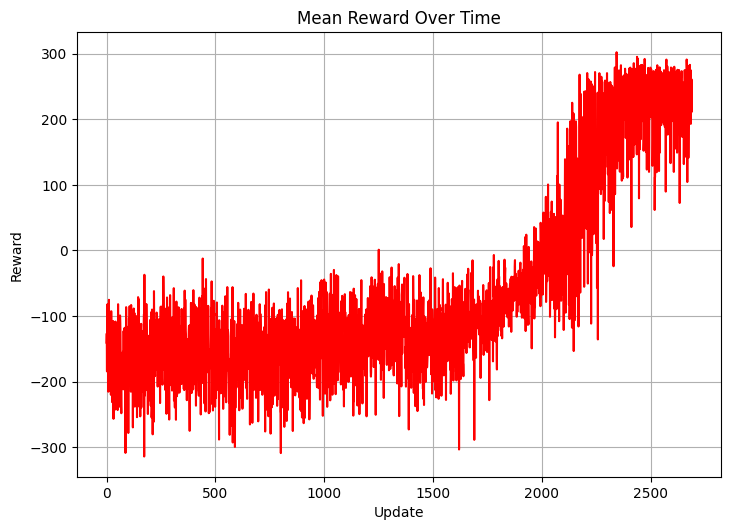

In [5]:
import gymnasium as gym

env_id = 'LunarLanderContinuous-v3'
max_steps = 1000
lr = 2.5e-4


ppo_model =  PPOAgent(env_id, max_steps=max_steps, total_timesteps=5e5, lr=lr, epsilon=0.1, num_envs=4, num_steps=512, num_epochs = 10, minibatch_size=16)

rewards = ppo_model.train()


[Timesteps: 5120, Min Episode: 53]
[53, 53, 54, 54]
Gradient norm: 1.7028
Reward (mean over envs): -120.77 | Avg Reward (last 10): -163.19
Actor_loss (mean over envs): -0.00 | Critic_loss (mean over envs): 0.91
Training time: 0:00:09

[Timesteps: 10240, Min Episode: 105]
[109, 105, 109, 110]
Gradient norm: 2.0198
Reward (mean over envs): -155.14 | Avg Reward (last 10): -143.84
Actor_loss (mean over envs): -0.00 | Critic_loss (mean over envs): 0.87
Training time: 0:00:19

[Timesteps: 15360, Min Episode: 160]
[161, 160, 161, 167]
Gradient norm: 3.4285
Reward (mean over envs): -102.48 | Avg Reward (last 10): -129.65
Actor_loss (mean over envs): -0.00 | Critic_loss (mean over envs): 0.73
Training time: 0:00:28

[Timesteps: 20480, Min Episode: 209]
[215, 209, 214, 219]
Gradient norm: 3.3740
Reward (mean over envs): -110.06 | Avg Reward (last 10): -125.61
Actor_loss (mean over envs): -0.00 | Critic_loss (mean over envs): 0.66
Training time: 0:00:37

[Timesteps: 25600, Min Episode: 239]
[239

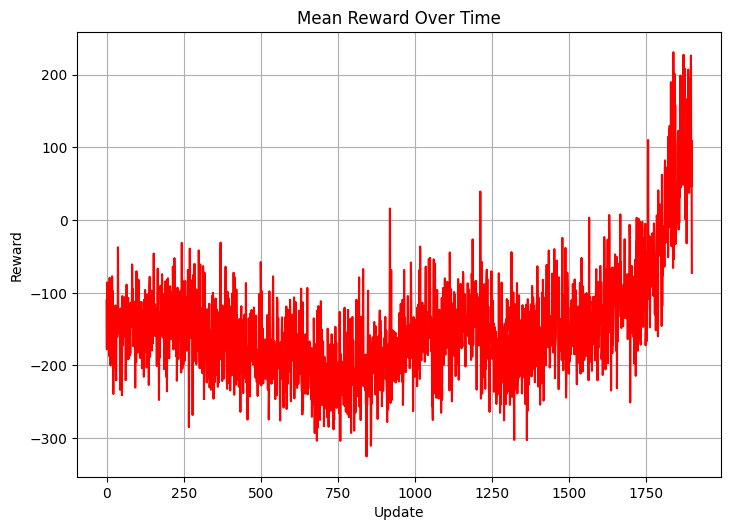

In [12]:
import gymnasium as gym

env_id = 'LunarLanderContinuous-v3'
max_steps = 1000
lr = 2.5e-4


ppo_model_GAE =  PPOAgent(env_id, max_steps=max_steps, total_timesteps=3e5, lr=lr, epsilon=0.1, num_envs=4, num_steps=512, num_epochs=10, minibatch_size=16, is_GAE=True)
rewards_GAE = ppo_model_GAE.train()

In [24]:
import gymnasium as gym
import torch
import numpy as np
from gymnasium.wrappers import RecordVideo
import os

# Create folder to save the video
video_folder = "./video"
os.makedirs(video_folder, exist_ok=True)

# Wrap the environment with RecordVideo
env = gym.make(env_id, render_mode='rgb_array')
env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True, name_prefix=env_id)

num_episodes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

episode_rewards = []

for i in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    episode_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            mean, std, _ = ppo_model.policy_net(state)
            print(std)
            break
            action = torch.tanh(mean).squeeze(0).cpu().numpy()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

    episode_rewards.append(episode_reward)
    print(f"Episode {i+1} Reward: {episode_reward}")

env.close()

episode_rewards = np.array(episode_rewards)
print(f"Average Reward over {num_episodes} episodes: {np.mean(episode_rewards)}")


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


tensor([0.4696, 0.4197], device='cuda:0')
Episode 1 Reward: 0
tensor([0.4696, 0.4197], device='cuda:0')
Episode 2 Reward: 0
tensor([0.4696, 0.4197], device='cuda:0')
Episode 3 Reward: 0
tensor([0.4696, 0.4197], device='cuda:0')
Episode 4 Reward: 0
tensor([0.4696, 0.4197], device='cuda:0')
Episode 5 Reward: 0
tensor([0.4696, 0.4197], device='cuda:0')
Episode 6 Reward: 0
tensor([0.4696, 0.4197], device='cuda:0')
Episode 7 Reward: 0
tensor([0.4696, 0.4197], device='cuda:0')
Episode 8 Reward: 0
tensor([0.4696, 0.4197], device='cuda:0')
Episode 9 Reward: 0
tensor([0.4696, 0.4197], device='cuda:0')
Episode 10 Reward: 0
Average Reward over 10 episodes: 0.0


In [23]:
import gymnasium as gym
import torch
import numpy as np
from gymnasium.wrappers import RecordVideo
import os

# Create folder to save the video
video_folder = "./video"
os.makedirs(video_folder, exist_ok=True)

# Wrap the environment with RecordVideo
env = gym.make(env_id, render_mode='rgb_array')
env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True, name_prefix=env_id + "-GAE")

num_episodes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

episode_rewards = []

for i in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    episode_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            mean, std, _ = ppo_model_GAE.policy_net(state)
            print(std)
            break
            action = torch.tanh(mean + std * torch.randn_like(std)).squeeze(0).cpu().numpy()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

    episode_rewards.append(episode_reward)
    print(f"Episode {i+1} Reward: {episode_reward}")

env.close()

episode_rewards = np.array(episode_rewards)
print(f"Average Reward over {num_episodes} episodes: {np.mean(episode_rewards)}")


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


tensor([0.2571, 0.3028], device='cuda:0')
Episode 1 Reward: 0
tensor([0.2571, 0.3028], device='cuda:0')
Episode 2 Reward: 0
tensor([0.2571, 0.3028], device='cuda:0')
Episode 3 Reward: 0
tensor([0.2571, 0.3028], device='cuda:0')
Episode 4 Reward: 0
tensor([0.2571, 0.3028], device='cuda:0')
Episode 5 Reward: 0
tensor([0.2571, 0.3028], device='cuda:0')
Episode 6 Reward: 0
tensor([0.2571, 0.3028], device='cuda:0')
Episode 7 Reward: 0
tensor([0.2571, 0.3028], device='cuda:0')
Episode 8 Reward: 0
tensor([0.2571, 0.3028], device='cuda:0')
Episode 9 Reward: 0
tensor([0.2571, 0.3028], device='cuda:0')
Episode 10 Reward: 0
Average Reward over 10 episodes: 0.0
